# Intro

Welcome to the interactive labeling notebook!

The notebook proceeds as follows:

1. **Import** libraries
2. Define **paths** to data
3. **Label** ROI images using a simple GUI
5. **Visualize** results
6. **Save** results


- If you need to restart a session, don't worry. Your results are continuously saved in the CSV file and you can just start from where you left off.
- We recommend labeling one session at a time so that the results can be saved with the data.

# Import libraries

Widen the notebook

In [1]:
%load_ext autoreload
%autoreload 2

# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

Import basic libraries

In [2]:
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

Import `roicat`

In [3]:
# %load_ext autoreload
# %autoreload 2
import roicat

# Find paths to data

##### Prepare list of paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_custom_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [4]:
dir_data = r'/Users/josh/analysis/data/ROICaT/classification/stat_s2p'


path_stat = str(Path(dir_data) / 'stat.npy')
path_ops = str(Path(dir_data) / 'ops.npy')

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=[path_stat],
    paths_opsFiles=[path_ops],
    new_or_old_suite2p='new',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Label data

How to use this GUI:
- Each image will be shown one at a time. You can go to previous and next images by using the ***Left*** and ***Right*** arrow keys, and can close the GUI by pressing the ***Escape*** key.
- Label the image by pressing any key on your keyboard. This key will be used as the label. After each key press, the following occurs:
    1. The results will be saved as a CSV file at `path_csv` (will be a temporary file if not specified)
    2. The results will also be stored in the python object as `Image_labeler_obj.labels_`.
    2. The GUI should progress to the next image.
    3. Finish labeling by closing out of the GUI window or pressing the user defined '`end_key`' (***Escape*** by default).
- The results are stored in a temporary CSV file with two columns: 'index' and 'label'. This file can be used to recover lost labeling session data. We will save more comprehensive results files at the end of the notebook.
    - **'index'**: The index within the data object. 0-indexed.
    - **'label'**: The key pressed for that image in the labeling GUI.
- To start at a different image index than 0, change the `start_index` argument.

In [6]:
images = data.ROI_images[0]

## Run the Image_labeler class
with roicat.helpers.Image_labeler(
    image_array=images, 
    start_index=0,  ## Change the starting image index here.
    path_csv=None,  ## If None, then a temporary path will be used.
    resize_factor=10.0,  
    verbose=True,
    key_end='Escape',  ## Closes GUI
    key_prev='Left',  ## Goes to previous image
    key_next='Right',  ## Goes to next image
) as labeler:  ## Running this object within a context manager allows it to crash gracefully
    labeler.run()
    


Image 0: 1
Image 1: 2
Image 2: 3
Image 3: 1
Image 4: 2
Image 5: 3
Image 6: 1
Image 7: 2
Image 8: 3
Image 9: 1
Image 10: 2
Image 11: 3
Image 12: 1
Image 13: 2
Image 14: 3
Image 15: 1
Image 16: 2
Image 17: 3
Image 18: 1
Image 19: 2
Image 20: 3
Image 21: 1
Image 22: 2
Image 23: 3
Image 24: 1
Image 25: 2
Image 26: 3
Image 27: 1
Image 28: 2
Image 29: 3
Image 30: 1
Image 31: 2
Image 32: 3
Image 33: 1
Image 34: 2
Image 35: 3
Image 36: 1
Image 37: 2
Image 38: 3
Image 39: 1
Image 40: 2
Image 41: 3
Image 42: 1
Image 43: 2
Image 44: 3
Image 45: 1
Image 46: 2
Image 47: 3
Image 48: 2
Image 49: 3
Image 50: 2
Image 51: 1
Image 52: 2
Image 53: 3
Image 54: 1
Image 55: 2
Image 56: 3
Image 57: 1
Image 58: 2
Image 59: 3
Image 60: 1
Image 61: 2
Image 62: 3
Image 63: 1
Image 64: 2
Image 65: 3
Image 66: 1
Image 67: 2
Image 68: 3
Image 69: 1
Image 70: 2
Image 71: 3
Image 72: 1
Image 73: 2
Image 74: 3
Image 75: 1
Image 76: 2
Image 77: 3
Image 78: 1
Image 79: 2
Image 80: 3
Image 81: 1
Image 82: 2
Image 83: 2
Im

TclError: can't invoke "destroy" command: application has been destroyed

In [8]:
path_csv = labeler.path_csv
labels = labeler.get_labels(kind='dataframe')

print(f"Number of labeled ROIs: {len(labels['index'])}")
print(f"path to csv file: {path_csv}")

Number of labeled ROIs: 502
path to csv file: /var/folders/gb/td_6747j3_z81x0r_38hyw180000gn/T/roicat_labels_20230621_161258.csv


# Visualize results

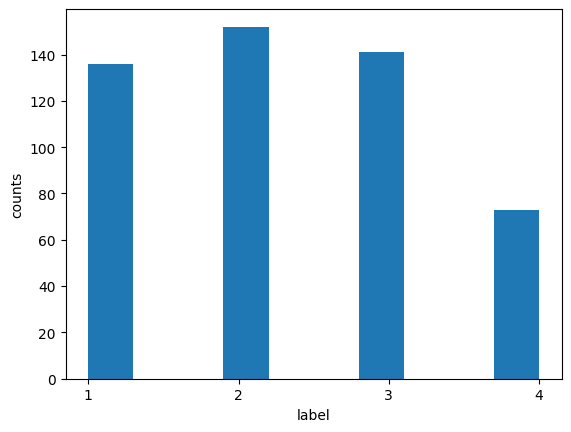

In [9]:
plt.figure()
plt.hist(labels['label']);
plt.xlabel('label');
plt.ylabel('counts');

In [10]:
roicat.visualization.display_labeled_ROIs(
    images=images,
#     labels=labels['label'].astype(np.int64),
    labels=labels,
    max_images_per_label=10,
    figsize=(10, 3),
    fontsize=25,
    shuffle=False,
)

AttributeError: module 'roicat.visualization' has no attribute 'display_labeled_ROIs'

# Save results

The results file can be opened using any of the following methods:
1. `roicat.helpers.pickle_load(path)`
2. `np.load(path)`
3. 
``` 
import pickle
with open(path_save, mode='rb') as f:
    test = pickle.load(f)
  ```

##### Make the results dictionary

In [11]:
data_info = data.serializable_dict  ## pull out the data from the data object into a dictionary
[data_info.pop(key) for key in ['ROI_images', 'spatialFootprints'] if key in data_info]  ## remove the large data items from the data object

results = {
    'labels': labels,
    'images': images,
    'data_info': data_info,
}

In [12]:
display(results)

{'labels': {'index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 

##### Save the results dictionary

In [13]:
dir_save = r'/Users/josh/analysis/outputs/ROICaT/classification/labeling_interactive'
filename_save = 'test'

path_save = str(Path(dir_save).resolve() / (filename_save + '.ROICaT.labeling.results' + '.pkl'))
print(f'path_save: {path_save}')

roicat.helpers.pickle_save(results, path_save)

path_save: /Users/josh/analysis/outputs/ROICaT/classification/labeling_interactive/test.ROICaT.labeling.results.pkl


# Thank you
If you encountered any difficulties, please let us know at the issues page: https://github.com/RichieHakim/ROICaT/issues

---
# Extras

## Merge and convert CSV files into a results file

##### Make labels dataframe

In [ ]:
import csv

path_csv = r'/home/rich/Desktop/test.csv'

with open(path_csv, 'r') as f:
    lines = np.array([line for line in csv.reader(f)], dtype=str)
    labels = {}
    labels['index'] = np.array(lines[1:, 0], dtype=np.int64)
    labels['label'] = lines[1:, 1]

##### Make images array

In [ ]:
dir_data = r'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230420/'


path_stat = str(Path(dir_data) / 'stat.npy')
path_ops = str(Path(dir_data) / 'ops.npy')

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=[path_stat],
    paths_opsFiles=[path_ops],
    new_or_old_suite2p='new',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

images = data.ROI_images[0]

##### Make the results dictionary

In [ ]:
data_info = data.serializable_dict  ## pull out the data from the data object into a dictionary
[data_info.pop(key) for key in ['ROI_images', 'spatialFootprints'] if key in data_info]  ## remove the large data items from the data object

results = {
    'labels': labels,
    'images': images,
    'data_info': data_info,
}

##### Save the results dictionary

In [ ]:
dir_save = r'/home/rich/Desktop/'
filename_save = 'test'

path_save = str(Path(dir_save).resolve() / (filename_save + '.ROICaT.labeling.results' + '.pkl'))
print(f'path_save: {path_save}')

roicat.helpers.pickle_save(results, path_save)